In [97]:
import numpy as np
import emcee
import pandas as pd
import time
from multiprocessing import Pool

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# %config InlineBackend.figure_format = 'retina'

In [5]:
def gen_data(times, baseline=0, t_exp=0, alpha=2, 
             amplitude=25, sigma_sys=5):
    '''
    Generate a simple SN Ia-like light curve
    
    Parameters
    ----------
    
    times : array-like
        The times at which the simulated data should be generated.
        Times are in units of days.
    
    baseline : float, optional (default=0)
        The baseline value for the flux of the transient in the 
        telescope system.
    
    t_exp : float, optional (default=0)
        The time of explosion for the SN.
    
    alpha : float, optional (default=2)
        Power-law index for the initial rise of the SN.
    
    amplitude : float, optional (default=25)
        Normalizing amplitude for rise of the SN, the default value
        is determined by assuming an alpha=2 increase in flux, 
        m_peak = 15 mag, and a 20 d rise time for the SN.
    
    sigma_sys : float, optional (default=5)
        The systematic noise present in the light curves due to 
        the telescope system. The default value is determined from 
        assuming a telescope limiting magnitude of 21.5.
    
    Returns
    -------
    cnts : array-like, shape=shape(times)
        The counts corresponding to the SN flux, after taking into 
        account the noise associated with the detector
    
    cnts_unc : array-like, shape=shape(times)
        Uncertainty in the number of counts from the SN
    '''
    
    cnts = np.zeros_like(times)
    cnts_unc = np.zeros_like(times)

    pre_explosion = np.logical_not(times > t_exp)
    cnts[pre_explosion] = np.random.normal(baseline, sigma_sys, size=sum(pre_explosion))
    cnts_unc[pre_explosion] = np.ones_like(times)[pre_explosion]*sigma_sys

    sn_flux = amplitude*(times[~pre_explosion] - t_exp)**alpha
    sn_with_random_noise = sn_flux + np.random.normal(np.zeros_like(sn_flux), np.sqrt(sn_flux))
    sn_with_random_plus_sys = sn_with_random_noise + np.random.normal(baseline, sigma_sys, size=len(sn_flux))

    # total uncertainty = systematic + Poisson
    sn_uncertainties = np.hypot(np.sqrt(np.maximum(sn_with_random_noise, np.zeros_like(sn_with_random_noise))), 
                                sigma_sys)

    cnts[~pre_explosion] = sn_with_random_plus_sys
    cnts_unc[~pre_explosion] = sn_uncertainties

    return cnts, cnts_unc

<IPython.core.display.Javascript object>


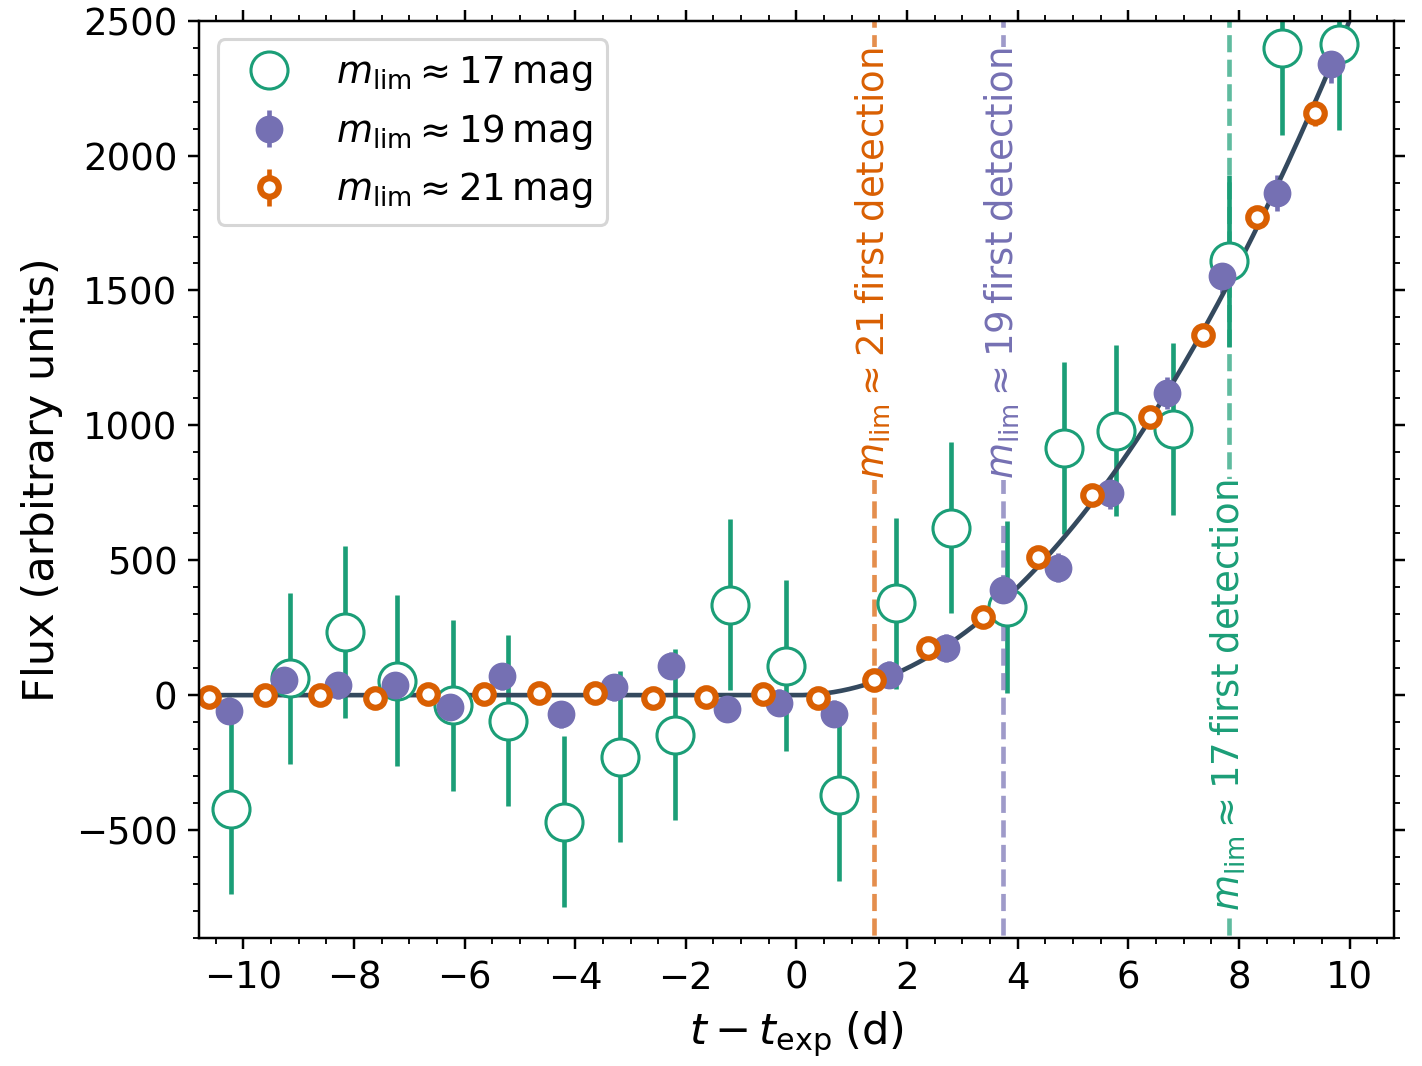

7.816098562188298
3.729520189388719
1.3947263088839152


In [100]:
np.random.seed(42)

t_grid = np.linspace(-21,14, 500)
signal = np.zeros_like(t_grid)
signal[t_grid > 0] = 25*t_grid[t_grid > 0]**2

# color brewer
color_dict = {'19': '#7570b3', 
              '21': '#d95f02', 
              '17': '#1b9e77',
              'signal': '#34495e',
              'w': 'w'}

fig, ax = plt.subplots()

ax.plot(t_grid, signal, color=color_dict['signal'])

for label, sigma_sys, mew, mfc, col_key, ms, ytext in zip([r"$m_\mathrm{lim} \approx 17\,\mathrm{mag}$",
                                                r"$m_\mathrm{lim} \approx 19\,\mathrm{mag}$", 
                                                r"$m_\mathrm{lim} \approx 21\,\mathrm{mag}$"], 
                                               [317, 50, 8], 
                                               [1, 1, 2], ['w','19','w'], 
                                               ['17', '19', '21'],
                                                  [12,8,6], [-800,800,800]):
    times = np.arange(-21,14, dtype=float) + np.random.uniform(-1/24,1/24,size=35) + np.random.uniform()
    cnts, cnts_unc = gen_data(times, sigma_sys=sigma_sys)
    det = np.where(cnts/cnts_unc > 4)
    print(times[det[0][0]])
    ax.errorbar(times, cnts, cnts_unc, 
                fmt='o', label=label, ms=ms,
                mew=mew, mfc=color_dict[mfc], color=color_dict[col_key])

    ax.vlines(times[det[0][0]],-1e6,1e6,
              linestyles='dashed', color=color_dict[col_key],
              alpha=0.7)
    ax.text(times[det[0][0]], ytext, 
            label.replace('\,\mathrm{mag}', '\,\mathrm{first \; detection}'),
            ha='center', va='bottom', rotation=90,
            color=color_dict[col_key], 
            bbox = {'fc': 'w', 'pad': 0.25, 'lw': 0},
            fontsize=12)
# ax.set_yscale("symlog", linthreshy=1e3)
ax.set_xlim(-10.8,10.8)
ax.set_ylim(-900,2500)
ax.set_ylabel("Flux (arbitrary units)", fontsize=14)
ax.set_xlabel("$t - t_\mathrm{exp} \; (\mathrm{d})$", fontsize=14)
ax.tick_params(labelsize = 12, which="both", top=True,  right=True)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(100))


ax.legend(fontsize=12)
fig.subplots_adjust(top=0.98,right=0.98,bottom=0.12,left=0.14)